### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Градиентный бустинг


**Общая информация**

**Срок сдачи:** 10 мая 2021, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 10 мая, -4 балла после 08:30 17 мая, -6 баллов после 08:30 24 мая, -8 баллов после 08:30 31 мая.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0221, Задание 4] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Считаем производные для функций потерь (1 балл)

Мы будем реализовать градиентный бустинг для 3 функций потерь:

1) MSE  $L(a(x_i), y_i) = (y_i - a(x_i)) ^ 2$

2) Экспоненциальная  $L(a(x_i), y_i) = exp( -a(x_i) y_i), y_i \in \{-1, 1\}$

3) Логистическая  $L(a(x_i), y_i) = \log (1 + exp( -a(x_i) y_i)), y_i \in \{-1, 1\}$

где $a(x_i)$ предсказание бустинга на итом объекте. 

Для каждой функции потерь напишите таргет, на который будет настраиваться каждое дерево в бустинге. 

Ваше решение тут

##  Реализуем градиентный бустинг (3 балла)

Реализуйте класс градиентного бустинга для классификации. Ваша реализация бустинга должна работать по точности не более чем на 5 процентов хуже чем GradientBoostingClassifier из sklearn. 


Детали реализации:

-- должно поддерживаться 3 функции потерь

-- сами базовые алгоритмы(деревья, линейные модели и тп) реализовать не надо, просто возьмите готовые из sklearn

-- в качестве функции потерь для построения одного дерева используйте MSE

-- шаг в бустинге можно не подбирать, можно брать константный

-- можно брать разные модели в качестве инициализации бустинга

-- должны поддерживаться следующие параметры:

а) число итераций
б) размер шага
в) процент случайных фичей при построении одного дерева
д) процент случайных объектов при построении одного дерева
е) параметры базового алгоритма (передавайте через **kwargs)

In [1]:
import numpy as np

from sklearn.datasets import load_wine
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
class MyGradientBoostingClassifier:

    def __init__(self, loss='mse', learning_rate=0.05, n_estimators=25, colsample=0.8, subsample=0.8, *args, **kwargs):
        """
        loss -- один из 3 лоссов:
        learning_rate -- шаг бустинга
        n_estimators -- число итераций
        colsample -- процент рандомных признаков при обучнеии одного алгоритма
        colsample -- процент рандомных объектов при обучнеии одного алгоритма
        args, kwargs -- параметры  базовых моделей
        """
        # Ваш код здесь
        self.loss = loss
        self.lr = learning_rate
        self.n_est = n_estimators
        self.colsample = colsample
        self.subsample = subsample
        self.args = args
        self.kwargs = kwargs
        self.model_init = None
    
    def approximate_boosting(self, F, y):
        if self.loss == 'mse':
            return -2 * (F - y)
        elif self.loss == 'exp':
            return np.exp(-F * y) * y
        elif self.loss == 'log':
            return y / (np.exp(F * y) + 1)
        raise NotImplementedError("Wrong loss function name when initializing MyGradientBoostingClassifier loss function")
    
    def fit(self, X, y, base_model=DecisionTreeRegressor, init_model=None):
        """
        X -- объекты для обучения:
        y -- таргеты для обучения
        base_model -- класс базовых моделей, например sklearn.tree.DecisionTreeRegressor
        init_model -- класс для первой модели, если None то берем константу (только для посл задания)
        """
        self.y = np.asarray(y)
        if init_model is None:
            F = np.full((X.shape[0],), 0.1)
        else:
            model = init_model()
            model.fit(X, y)
            F = model.predict(X)
            self.model_init = model
        y_pred = []
        self.models = []
        self.features = []

        num_col = np.int64(np.floor(self.colsample * X.shape[1]))
        num_spl = np.int64(np.floor(self.subsample * X.shape[0]))

        feature_indices = np.arange(X.shape[1])

        for i in range(self.n_est):

            cur_feature_ind = np.random.permutation(X.shape[1])[:num_col]
            cur_subsample_ind = np.random.permutation(X.shape[0])[:num_spl]

            self.features.append(cur_feature_ind)
            X_subsample = X[:, cur_feature_ind][cur_subsample_ind]
            y_subsample = y[cur_subsample_ind]

            cur_model = base_model(*self.args, **self.kwargs)
            y_t = self.approximate_boosting(F[cur_subsample_ind], y_subsample)
            cur_model.fit(X_subsample, y_t)
            self.models.append(cur_model)
            F += self.lr * cur_model.predict(X[:, cur_feature_ind])
     
    def predict(self, X):
        if self.model_init is None:
            F = np.full((X.shape[0],), 0.1)
        else:
            F = self.model_init.predict(X)
        for i, submodel in enumerate(self.models):
            F += self.lr * submodel.predict(X[:, self.features[i]])
        return np.rint(F)

In [3]:
my_clf = MyGradientBoostingClassifier()
clf = GradientBoostingClassifier()

In [4]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [5]:
my_clf.fit(X_train, y_train, DecisionTreeRegressor)
clf.fit(X_train, y_train)
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.9444444444444444
0.9444444444444444


## Подбираем параметры (2 балла)

Давайте попробуем применить Ваш бустинг для предсказаний цены домов в Калифорнии. Чтобы можно было попробовтаь разные функции потерь, переведем по порогу таргет в 2 класса: дорогие и дешевые дома.

В задании нужно

1) Построить график точности в зависимости от числа итераций на валидации.

2) Подобрать оптимальные параметры Вашего бустинга на валидации. 


In [6]:
from sklearn.datasets import fetch_california_housing
X, y = fetch_california_housing(return_X_y=True)

In [7]:
# Превращаем регрессию в классификацию
y = (y > 2.0).astype(int)
print(X.shape, y.shape)

(20640, 8) (20640,)


In [8]:
accuracies = []
for i in tqdm(range(1, 51)):
    clf = MyGradientBoostingClassifier(n_estimators=i)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
    clf.fit(X_train, y_train, base_model=DecisionTreeRegressor)
    accuracies.append(accuracy_score(y_test, clf.predict(X_test)))


100%|██████████| 50/50 [02:33<00:00,  3.08s/it]


Text(0.5, 1.0, 'MyGradBoosting model dependency on n_estimators')

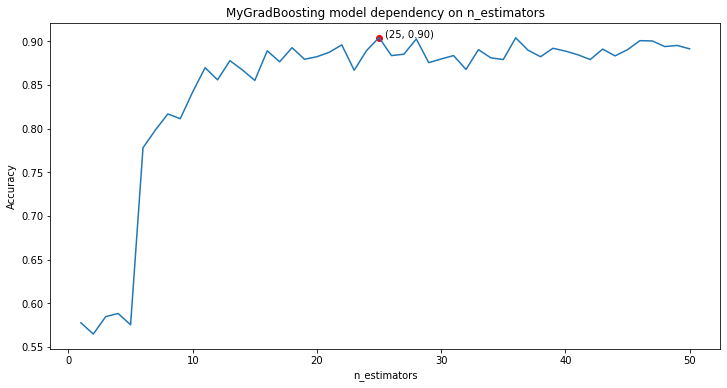

In [9]:
fig = plt.figure(figsize=(12, 6))
accuracies = np.asarray(accuracies)
n_est = np.arange(1, 51)
plt.plot(n_est, accuracies)
max_acc_ind = accuracies.argmax()
plt.scatter(n_est[max_acc_ind], accuracies[max_acc_ind], color='red')
plt.text(n_est[max_acc_ind] + 0.5, accuracies[max_acc_ind] + 0.001, f"({n_est[max_acc_ind]}, {accuracies[max_acc_ind]:1.2f})")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.title("MyGradBoosting model dependency on n_estimators")

In [10]:
optimal_params = [0] * 6
losses = ['mse', 'exp', 'log']
n_est = [5, n_est[max_acc_ind]]
lr = [0.001, 0.1, 0.5]
sub_samples = [0.5, 0.7, 1]
sub_features = [0.5, 0.7, 1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

for loss in tqdm(losses):
    for n in n_est:
        for learn_rate in tqdm(lr):
            for subs in sub_samples:
                for subf in sub_features:
                    my_clf = MyGradientBoostingClassifier(loss=loss, learning_rate=learn_rate, n_estimators=n, colsample=subf,subsample=subs)
                    my_clf.fit(X_train, y_train, base_model=DecisionTreeRegressor)
                    cur_acc = accuracy_score(y_test, my_clf.predict(X_test))
                    if cur_acc > optimal_params[0]:
                        optimal_params[0] = cur_acc
                        optimal_params[1] = loss
                        optimal_params[2] = n
                        optimal_params[3] = learn_rate
                        optimal_params[4] = subs
                        optimal_params[5] = subf

100%|██████████| 3/3 [00:12<00:00,  4.14s/it]

100%|██████████| 3/3 [00:10<00:00,  3.50s/it]

100%|██████████| 3/3 [00:11<00:00,  3.68s/it]

100%|██████████| 3/3 [03:28<00:00, 69.47s/it]


In [11]:
print(f"""
          Optimal params:
            Loss:            {optimal_params[1]},
            n_estimators:    {optimal_params[2]},
            learning rate:   {optimal_params[3]},
            Feature_sample:  {optimal_params[4]},
            Subsample:       {optimal_params[5]},

          Accuracy achieved: {optimal_params[0]}""")


          Optimal params:
            Loss:            log,
            n_estimators:    25,
            learning rate:   0.1,
            Feature_sample:  0.7,
            Subsample:       0.7,

          Accuracy achieved: 0.8968023255813954


## BooBag BagBoo (1 балл)



Попробуем объединить бустинг и бэгинг. Давайте

1) в качестве базовой модели брать не дерево решений, а случайный лес (из sklearn)

2) обучать N бустингов на бустрапированной выборке, а затем предикт усреднять

Попробуйте обе этих стратегии на данных из прошлого задания. Получилось ли улучшить качество? Почему?

In [12]:
from sklearn.ensemble import RandomForestRegressor

In [13]:
my_clf = MyGradientBoostingClassifier(loss=optimal_params[1], n_estimators=optimal_params[2], learning_rate=optimal_params[3], colsample=optimal_params[4], subsample=optimal_params[5])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
my_clf.fit(X_train, y_train, base_model=RandomForestRegressor)

In [14]:
print(f"Accuracy: {accuracy_score(y_test, my_clf.predict(X_test))}")

Accuracy: 0.8801679586563308


In [15]:
predictions = np.zeros((X_test.shape[0], ))
for i in tqdm(range(10)):
    indices = np.random.permutation(X_train.shape[0])[:X_test.shape[0] * 5]
    X = X_train[indices]
    y = y_train[indices]
    my_clf = MyGradientBoostingClassifier(loss=optimal_params[1], n_estimators=optimal_params[2], learning_rate=optimal_params[3], colsample=optimal_params[4], subsample=optimal_params[5])
    my_clf.fit(X, y, base_model=DecisionTreeRegressor)
    predictions += my_clf.predict(X_test)
predictions = np.rint(predictions / 10)

100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


In [16]:
print(f"Accuracy: {accuracy_score(y_test, predictions)}")

Accuracy: 0.8837209302325582


Точность оказалась меньше. Для случайного леса вероятнее всего просто оптимальные параметры должны быть другими, из-за чего точность проседает. В случае же с ансамблем это может быть связано с уменьшением выборки или уточнением работы алгоритма (вероятно, при поиске оптимальных параметров мы нашли очень удачный набор параметров)

## Умная инициализация (1 балл)

Попробуйте брать в качестве инициализации бустинга не константу, а какой-то алгоритм и уже от его предикта стартовать итерации бустинга. Попробуйте разные модели из sklearn: линейные модели, рандом форест, svm..

Получилось ли улучшить качество? Почему?



In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC, SVR

In [26]:
my_clf = MyGradientBoostingClassifier(loss=optimal_params[1], n_estimators=optimal_params[2], learning_rate=optimal_params[3], colsample=optimal_params[4], subsample=optimal_params[5])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
my_clf.fit(X_train, y_train, base_model=DecisionTreeRegressor, init_model=LinearRegression)

In [27]:
print(f"Accuracy Linear: {accuracy_score(y_test, my_clf.predict(X_test))}")

Accuracy Linear: 0.73557278208441


In [20]:
my_clf = MyGradientBoostingClassifier(loss=optimal_params[1], n_estimators=optimal_params[2], learning_rate=optimal_params[3], colsample=optimal_params[4], subsample=optimal_params[5])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
my_clf.fit(X_train, y_train, base_model=DecisionTreeRegressor, init_model=RandomForestRegressor)

In [21]:
print(f"Accuracy RandomForest: {accuracy_score(y_test, my_clf.predict(X_test))}")

Accuracy RandomForest: 0.7648578811369509


In [22]:
my_clf = MyGradientBoostingClassifier(loss=optimal_params[1], n_estimators=optimal_params[2], learning_rate=optimal_params[3], colsample=optimal_params[4], subsample=optimal_params[5])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
my_clf.fit(X_train, y_train, base_model=DecisionTreeRegressor, init_model=SVR)

In [23]:
print(f"Accuracy SVM: {accuracy_score(y_test, my_clf.predict(X_test))}")

Accuracy SVM: 0.8953488372093024


Опять таки побить нам ничего не удалось. Для преодоления топового скора нам надо дополнительно подбирать параметры под наши новые модели (комбинацию моделей). Это еще раз показывает, что подбор параметров - штука довольно индивидуальная.

## Фидбек (бесценно)

* Какие аспекты обучения  ансамблей Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

Хорошее дз. Но тут вероятно стоит как-нибудь подобрать все параметры для хотя бы обычного склерновского град бустинга, чтобы он очень хороший скор на датасете нашем показывал. Так хоть будет точно понятно, что весь этот подбор и улучшение архитектуры могут к чему-то привести. Это развеет все сомнения и подчеркнет важность параметров в нашей жизни:)

### ВАШ ОТЗЫВ ЗДЕСЬ



<img src='./perfect.jpg'>